In [16]:
% matplotlib inline
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.finance import candlestick_ohlc
import pandas as pd
import matplotlib.dates as mdates
import urllib, math
import numpy as np
import datetime as dt
from pandas import Series, DataFrame

# using styles
from matplotlib import style

### subplots

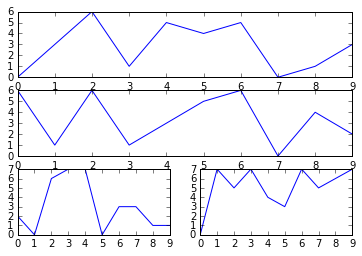

In [13]:
fig = plt.figure()

def create_plots():
    xs = []
    ys = []
    
    for i in range(10):
        x = i
        y = random.randrange(8)
        
        xs.append(x)
        ys.append(y)
    return xs, ys

# if subplot is desired, you have to assign a fig=plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(325)
ax4 = fig.add_subplot(326)

x, y = create_plots()
ax1.plot(x,y)

x, y = create_plots()
ax2.plot(x,y)

x, y = create_plots()
ax3.plot(x,y)

x, y = create_plots()
ax4.plot(x,y)

plt.show()

### subplot2grid

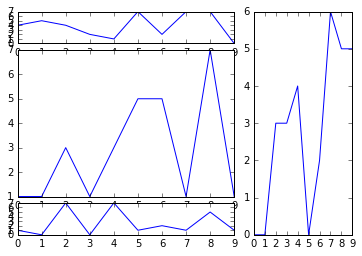

In [14]:
fig = plt.figure()

def create_plots():
    xs = []
    ys = []
    
    for i in range(10):
        x = i
        y = random.randrange(8)
        
        xs.append(x)
        ys.append(y)
    return xs, ys

# if subplot is desired, you have to assign a fig=plt.figure()
ax1 = plt.subplot2grid((6,3), (0,0), rowspan=1, colspan=2)
ax2 = plt.subplot2grid((6,3), (1,0), rowspan=4, colspan=2)
ax3 = plt.subplot2grid((6,3), (5,0), rowspan=1, colspan=2)
ax4 = plt.subplot2grid((6,3), (0,2), rowspan=6, colspan=1)

x, y = create_plots()
ax1.plot(x,y)

x, y = create_plots()
ax2.plot(x,y)

x, y = create_plots()
ax3.plot(x,y)

x, y = create_plots()
ax4.plot(x,y)

plt.show()

Stock to plot: t
('Currently pulling:', 't')


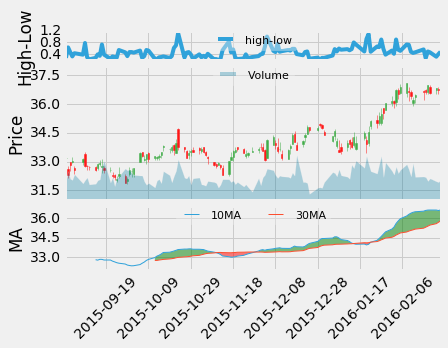

In [83]:
def graph_data(stock):
    print('Currently pulling:', stock)
    url = 'http://chartapi.finance.yahoo.com/instrument/1.0/'+stock+'/chartdata;type=quote;range=6m/csv'
    source_code = urllib.urlopen(url).read().decode()
    stock_data = []
    split_source = source_code.split('\n')
    
    for each_line in split_source:
        split_line = each_line.split(',')
        if len(split_line) == 6:
            if 'values' not in each_line:
                stock_data.append(split_line)
                
    df = DataFrame(stock_data, columns=['date','closp','highp','lowp','openp','volume'])
    def convdate(date):
        # can also return the datetime format and plot as it is, which is more straight-forward
        time = dt.datetime.strptime(date, '%Y%m%d')
        return int(mdates.date2num(time))
    df['numdate'] = df.date.apply(convdate)
    return df

def moving_average(values, window):
    weights = np.repeat(1.0, window)/window
    smas = np.convolve(values, weights, 'valid')
    return list(smas)

def high_low(highs, lows):
    return highs-lows

stock = raw_input('Stock to plot: ')
df = graph_data(stock)

date = np.array(df.numdate.tolist())
closep = np.array(df.closp.astype(float).tolist())
openp = np.array(df.openp.astype(float).tolist())
highp = np.array(df.highp.astype(float).tolist())
lowp = np.array(df.lowp.astype(float).tolist())
volume = np.array(df.volume.astype(float).tolist())

MA1 = 10
MA2 = 30

# reformat data into a list of tuples (d,o,h,l,c,v)
x=0
y=len(date)
new_list = []
while x<y:
    append_line = date[x], openp[x], highp[x], lowp[x],closep[x], volume[x] # tuple
    new_list.append(append_line)
    x += 1
    
# calculate moving average
ma1 = np.array([np.nan]*(MA1-1) + moving_average(closep, MA1))
ma2 = np.array([np.nan]*(MA2-1) + moving_average(closep, MA2))

# calculate high low valitility
hldiff = map(high_low, highp, lowp)

# plot
style.use('fivethirtyeight')
fig = plt.figure() # grid and starting location

ax1 = plt.subplot2grid((7,1), (0,0), rowspan = 1, colspan = 1)
plt.ylabel('High-Low')

# share the same x axis so that plots resizes together
ax2 = plt.subplot2grid((7,1), (1,0), rowspan = 4, colspan = 1, sharex = ax1)
plt.ylabel('Price')
# multi y axis, share x axis
ax2v = ax2.twinx()

ax3 = plt.subplot2grid((7,1), (5,0), rowspan = 2, colspan = 1, sharex = ax1)
plt.ylabel('MA')

# subplot 1
ax1.plot_date(date, hldiff,'-', label='high-low')
# control the number of ticks on y axis, and how to trim
ax1.yaxis.set_major_locator(mticker.MaxNLocator(nbins=3, prune='lower'))

# subplot 2
candlestick_ohlc(ax2,new_list,width=0.6,colorup='#41ad49',colordown='#ff1717')
ax2.yaxis.set_major_locator(mticker.MaxNLocator(nbins=6, prune='upper'))
# plot the second serie that will share the y axis
ax2v.fill_between(date, 0, volume, facecolor = '#0079a3', alpha = 0.3)
# a walk-around to add legend
ax2v.plot([],[], color = '#0079a3', label='Volume', alpha=0.3)
# turn off the y ticks on the second serie
ax2v.axes.yaxis.set_ticklabels([])
# shrink the size
ax2v.set_ylim(0, 3*volume.max())
# remove grid
ax2v.grid(False)

# subplot 3
ax3.plot_date(date, ma1, '-', linewidth = 1, label=str(MA1)+'MA')
ax3.plot_date(date, ma2, '-', linewidth = 1, label=str(MA2)+'MA')
ax3.fill_between(date, ma2, ma1, where=(ma1>ma2), alpha=0.5, facecolor='g')
ax3.fill_between(date, ma2, ma1, where=(ma1<ma2), alpha=0.5, facecolor='r')
ax3.yaxis.set_major_locator(mticker.MaxNLocator(nbins=4, prune='upper'))

# correct the date format
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
for label in ax3.xaxis.get_ticklabels():
    label.set_rotation(45)
ax3.xaxis.set_major_locator(mticker.MaxNLocator(10))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# designate the location and other properties of legend displaying
leg = ax1.legend(loc=9, ncol =2, prop={'size':11}, fancybox=True, borderaxespad=0)
leg.get_frame().set_alpha(0.4)
leg = ax2v.legend(loc=9, ncol =2, prop={'size':11}, fancybox=True, borderaxespad=0)
leg.get_frame().set_alpha(0.4)
leg = ax3.legend(loc=9, ncol =2, prop={'size':11}, fancybox=True, borderaxespad=0)
leg.get_frame().set_alpha(0.4)


plt.show()